### Data Science Assignment
**Objective**

* Develop a model to predict the 'Impact' of a book, a composite score achieved post-publication,
using its attributes and metadata.

* <font color="red"> This is a minimum viable pipeline to keep it within scope of interview process <red/>

In [1]:
import os
import tomllib
import pandas
import utils
import numpy

CONFIG = tomllib.load(open("config.toml", "rb"))["explore"]
WORKERS = os.cpu_count()
DATA_CHUNKS = 80

In [2]:
data = pandas.read_csv("books_task.csv")
data.columns

Index(['Unnamed: 0', 'Title', 'description', 'authors', 'publisher',
       'publishedDate', 'categories', 'Impact'],
      dtype='object')

In [3]:
# dropping unnamed column
data.drop(CONFIG['drop_columns'],axis=1,inplace=True)
data.columns

Index(['Title', 'description', 'authors', 'publisher', 'publishedDate',
       'categories', 'Impact'],
      dtype='object')

In [4]:
data["description"], print(f"missing descriptiton {len(data['description'][data['description'].isnull()])/len(data)}")

missing descriptiton 0.09190190594273522


(0                                                       NaN
 1         Philip Nel takes a fascinating look into the k...
 2         This resource includes twelve principles in un...
 3         Julia Thomas finds her life spinning out of co...
 4         In The Church of Christ: A Biblical Ecclesiolo...
                                 ...                        
 138719    "The Magic of the Soul, Applying Spiritual Pow...
 138720    Autodesk Inventor 2017 Essentials Plus provide...
 138721    During a school trip to Ellis Island, Dominick...
 138722    Everyone in the village of Friedensdorf is hap...
 138723    Alex-Li Tandem sells autographs. His business ...
 Name: description, Length: 138724, dtype: object,
 None)

There are description column missingg in the dataset. It can be handled as..
* dropping, since it is less than 1%
* filling with missing information tag, can be captured by the contextual embedding or a language model.
* filling these values with public sources like goodReads, wikipedia etc.

SAME IS ALSO APPLICABLE FOR "AUTHOR" AND "PUBLISHED DATES"

In [5]:
# filling missing information as a string
data["description"] = data["description"].fillna(CONFIG["missing_string"])

In [6]:
data["authors"]

0                          ['Julie Strain']
1                            ['Philip Nel']
2                          ['David R. Ray']
3                       ['Veronica Haddon']
4                      ['Everett Ferguson']
                        ...                
138719               ['Patrick J. Harbula']
138720    ['Daniel Banach', 'Travis Jones']
138721                  ['Elvira Woodruff']
138722                                  NaN
138723                      ['Zadie Smith']
Name: authors, Length: 138724, dtype: object

* Considering that we are planning to use a Language model, we can simply remove the square brackets and the extra quotes from names
* missing values can be handles in several way, but we will add imputation text since we are working with text model.
* There is great potential for feature engineering here. adding columns for "multi-authors" like:  num_authors, avg_authors_impact, total_authors_publication
* For single author, we can add a column for "avg_historical_impact" based on publishe_date.

In [7]:
data["authors"] = data["authors"].fillna(CONFIG["missing_string"])

def clean_authors(author_list: str) -> str:
    return author_list.replace("'", "").replace("[", "").replace("]", "")

#! Parallel MAP: not optimal since data too small
# data["authors"] = utils.df_parallel_map(clean_authors, data["authors"], n_jobs=WORKERS, chunks=DATA_CHUNKS, action="cleaning authors")

data["authors"] = data["authors"].map(clean_authors)
data["authors"]


0                        Julie Strain
1                          Philip Nel
2                        David R. Ray
3                     Veronica Haddon
4                    Everett Ferguson
                     ...             
138719             Patrick J. Harbula
138720    Daniel Banach, Travis Jones
138721                Elvira Woodruff
138722                      not found
138723                    Zadie Smith
Name: authors, Length: 138724, dtype: object

In [8]:
data["publisher"], print(f'missing {(data["publisher"].isna().sum() / len(data) * 100)}%')

missing 0.0%


(0            Smithsonian Institution
 1                          A&C Black
 2                            OUP USA
 3                          iUniverse
 4         Wm. B. Eerdmans Publishing
                      ...            
 138719            Love & Logic Press
 138720              SDC Publications
 138721         Scholastic Paperbacks
 138722    Wm. B. Eerdmans Publishing
 138723                       Vintage
 Name: publisher, Length: 138724, dtype: object,
 None)

In [9]:
data["publisher"].value_counts()

publisher
Tan Books & Pub               3635
Simon and Schuster            3600
Smithsonian Institution       3216
Penguin                       2788
Wm. B. Eerdmans Publishing    2563
                              ... 
Rider                            1
Robert Davies Pub                1
Astrology Sight                  1
McQueen Enterprises              1
Torah Aura Prod                  1
Name: count, Length: 12855, dtype: int64

* since this is more like a caegory, wecan group the less frequent into a bucket to reduce cardinality. But there could be outliers hiding in there.
* No preprocessing required in particular.

In [10]:
data["publishedDate"].value_counts()

publishedDate
2000          3362
2004          3218
1999          3159
2002          3110
2003          3070
              ... 
1981-12-18       1
1969-11-15       1
2000-03-05       1
2004-07-24       1
2007-08-26       1
Name: count, Length: 10819, dtype: int64

* we can potentially fetch incomplete/missing dates from the public sources.
* for simplicity, I am only going to retain the years from this data.

In [11]:
data["publishedDate"] = data["publishedDate"].fillna("10")

def extract_year(date_str: str) -> str:
    return date_str.split("-")[0]

data["publishedDate"] = data["publishedDate"].map(extract_year)
data["publishedDate"].value_counts()

publishedDate
2004     7196
2005     6976
2003     6794
2002     6400
2000     6083
         ... 
1797        1
1712        1
1947*       1
1814        1
2014*       1
Name: count, Length: 257, dtype: int64

* presence of symbols like `*` and `?` could potetially be a disputed year of publication. Thes can be potentially investigated and create features out of it.
* what is the potential effect of disputed year on the impact of the book?
* dropping for simplicity.

In [12]:
# code to only retain numbers in a string
def date_cleaner(string: str) -> str:
    numbers =  ''.join(filter(str.isdigit, string))
    if len(numbers) == 4:
        return numbers
    else:
        return numpy.nan

data["publishedDate"] = data["publishedDate"].map(date_cleaner)
data["publishedDate"].value_counts()

publishedDate
2004    7196
2005    6978
2003    6794
2002    6400
2000    6084
        ... 
1802       1
1765       1
1841       1
1791       1
1794       1
Name: count, Length: 233, dtype: int64

In [13]:
data["categories"].value_counts(), len(data["categories"][data["categories"].isnull()])

(categories
 ['Fiction']                      23419
 ['Religion']                      9459
 ['History']                       9330
 ['Juvenile Fiction']              6643
 ['Biography & Autobiography']     6324
                                  ...  
 ['Christianity']                    79
 ['Young Adult Nonfiction']          79
 ['Railroads']                       78
 ['Brothers and sisters']            76
 ['Automobiles']                     74
 Name: count, Length: 100, dtype: int64,
 0)

* we can simply remove the symbols and quotes from the string
* We can potentially merge subset categories into super-set category. (e.g. "Christianity" and "Judaism" can be merged into "Relegion")

In [14]:
def category_cleaner(category_string: str) -> str:
    return category_string.replace("[", "").replace("]", "").replace("'", "").lower()

data["categories"] = data["categories"].map(category_cleaner)
data["categories"]

0           comics & graphic novels
1         biography & autobiography
2                          religion
3                           fiction
4                          religion
                    ...            
138719          body, mind & spirit
138720                    computers
138721             juvenile fiction
138722             juvenile fiction
138723                      fiction
Name: categories, Length: 138724, dtype: object

In [15]:
data.columns

Index(['Title', 'description', 'authors', 'publisher', 'publishedDate',
       'categories', 'Impact'],
      dtype='object')

<Axes: >

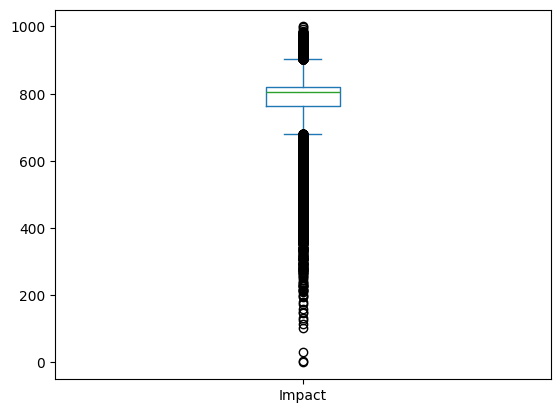

In [16]:
data["Impact"].plot.box()

* left skewed distribution, can be root transformed for simplification.
* There can potentially be outliers/missing valies than can explain very-low or very-high values.

<Axes: >

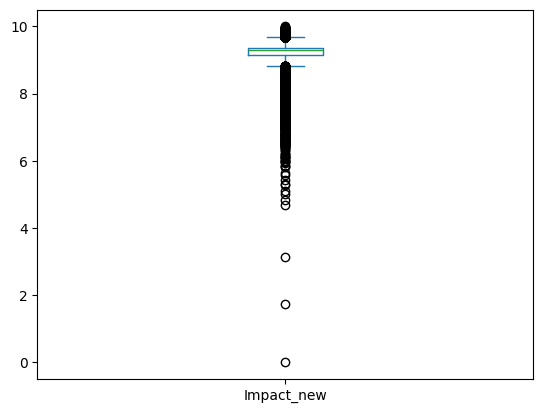

In [18]:
def impact_transform(num: float) -> float:
    return num**(1/3)

def impact_inverse_transform(num: float) -> float:
    return num**2

data["Impact_new"] = data["Impact"].map(impact_transform)
data["Impact_new"].plot.box()

* simple transformations are going to help directly, this especially lower values require explaination via feature engineering.

In [15]:
from transformers import AutoModel, AutoTokenizer

In [16]:
model = AutoModel.from_pretrained('distilbert-base-uncased')
tokenizer = AutoTokenizer.from_pretrained('distilbert-base-uncased')
# list(model.named_children())

In [41]:
text = "Hello, my dog is cute"
outs = tokenizer(text, return_tensors="pt")
outs

{'input_ids': tensor([[  101,  7592,  1010,  2026,  3899,  2003, 10140,   102]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1]])}

In [44]:
model_out = model(**outs)

In [48]:
model_out.last_hidden_state.shape

torch.Size([1, 8, 768])

TypeError: tuple indices must be integers or slices, not tuple